In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d.axes3d import Axes3D    # allows 3D plots
%matplotlib inline
from IPython.display import Image                 # only for embedding images

# Hauptkomponentenanalyse *PCA*

### Ziele:
- Wichtigste Information aus Daten extrahieren
- Unwichtige Daten verwerfen
- Beschreibung der Daten vereinfachen
- Struktur in den Daten erkennen

### Hauptkomponenten, principal componentc *pcs*
### Bildbearbeitung: Karhunen-Loève-Transformation

## Übersicht
- Maximale Varianz
- Projektion und Rücktransformation
- Erweiterung auf mehrere Dimensionen
- Kovarianz-Matrix
    - Singularwertzerlegung *SVD*
    - Eigenwerte und Eigenvektoren
- Hauptkomponenten
    - Projektion
    - Unterräume
    - kumulierte Varianz
- Beispiele
    - Säugetiere II
    - Bilder
    - Bildanalyse
    - Gesichtserkennung
- Python: `sklearn.PCA`    

## Beispiel: Gewichte von Säugetieren
Gleichberechtigte Variablen $X_1$ log-Körpergewicht und $X_2$ log-Gehirngewicht

In [3]:
'''mammals data set example'''
import pandas as pd
animals = pd.read_csv('data/animals.txt', sep='\t')  # read data
animals.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 11 columns):
Species        62 non-null object
BodyWt         62 non-null float64
BrainWt        62 non-null float64
NonDreaming    48 non-null float64
Dreaming       50 non-null float64
TotalSleep     58 non-null float64
LifeSpan       58 non-null float64
Gestation      58 non-null float64
Predation      62 non-null int64
Exposure       62 non-null int64
Danger         62 non-null int64
dtypes: float64(7), int64(3), object(1)
memory usage: 5.4+ KB


In [4]:
data = animals[['BodyWt', 'BrainWt', 'Species']]
data = data.dropna(axis=0)    # drop lines (axis=0) without all values
data['log_BodyWt'] = np.log10(animals['BodyWt'])
data['log_BrainWt'] = np.log10(animals['BrainWt'])-3  # g -> kg
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 5 columns):
BodyWt         62 non-null float64
BrainWt        62 non-null float64
Species        62 non-null object
log_BodyWt     62 non-null float64
log_BrainWt    62 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.9+ KB


## Statistik
Grundgesamtheit (?)

In [5]:
print(data.describe())

            BodyWt      BrainWt  log_BodyWt  log_BrainWt
count    62.000000    62.000000   62.000000    62.000000
mean    198.789984   283.134194    0.580886    -1.636229
std     899.158011   930.278942    1.356357     1.062507
min       0.005000     0.140000   -2.301030    -3.853872
25%       0.600000     4.250000   -0.225963    -2.373713
50%       3.342500    17.250000    0.524036    -1.763257
75%      48.202500   166.000000    1.678070    -0.780110
max    6654.000000  5712.000000    3.823083     0.756788


In [6]:
print(data[['Species', 'BodyWt', 'BrainWt']]
      .sort_values(by='BodyWt', ascending=False)
      .head(16))

            Species   BodyWt  BrainWt
0   Africanelephant  6654.00   5712.0
4     Asianelephant  2547.00   4603.0
20          Giraffe   529.00    680.0
28            Horse   521.00    655.0
11              Cow   465.00    423.0
40            Okapi   250.00    490.0
23          Gorilla   207.00    406.0
44              Pig   192.00    180.0
13           Donkey   187.10    419.0
7    Braziliantapir   160.00    169.0
29           Jaguar   100.00    157.0
24         Grayseal    85.00    325.0
33              Man    62.00   1320.0
19   Giantarmadillo    60.00     81.0
53            Sheep    55.50    175.0
9        Chimpanzee    52.16    440.0


In [7]:
print(data[['Species', 'BodyWt', 'BrainWt']]
      .sort_values(by='BrainWt', ascending=False)
      .head(10))

            Species   BodyWt  BrainWt
0   Africanelephant  6654.00   5712.0
4     Asianelephant  2547.00   4603.0
33              Man    62.00   1320.0
20          Giraffe   529.00    680.0
28            Horse   521.00    655.0
40            Okapi   250.00    490.0
9        Chimpanzee    52.16    440.0
11              Cow   465.00    423.0
13           Donkey   187.10    419.0
23          Gorilla   207.00    406.0


data X is of type <class 'numpy.ndarray'> and has shape (2, 62)


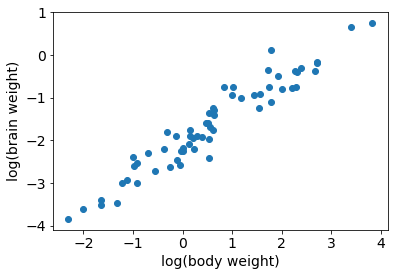

In [8]:
'''dependence of weights: body vs. brain'''
X = np.asarray(data[['log_BodyWt', 'log_BrainWt']]).T
print('data X is of type {} and has shape {}'.format(type(X), X.shape))
fig = plt.figure(figsize=(6, 4))
plt.scatter(X[0], X[1])
plt.ylabel('log(brain weight)')
plt.xlabel('log(body weight)');

## *Eine* Variable?

## Größte Varianz

### Mischung von zwei Variablen

$$Y = a\cdot X_1 + b\cdot X_2$$
mit $X_1$: log(BodyWt) und $X_2$: log(BrainWt)

### = Projektion auf Unterraum $Y$
eindimensional

### maximale Varianz?

$$\begin{align}
\mathrm{Var}(Y) &= \mathcal{E}\Bigl(\bigl(Y-\mathcal{E}(Y)\bigr)^2\Bigr) \\
           ...  &= a^2 \mathrm{Var}(X_1) + b^2 \mathrm{Var}(X_2) + 2\cdot a\cdot b\cdot \mathrm{Cov}(X_1, X_2)
\end{align}$$

Var(X1)=1.810  Var(X2)=1.111  Cov(X1,X2)=1.383
Max variance is 2.865 located at angle phi=38°


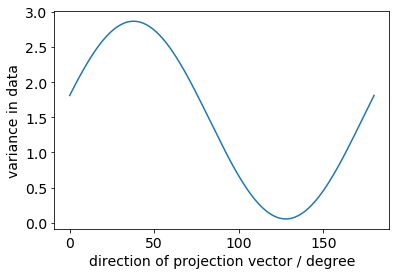

In [10]:
'''variance depending on "rotating" through X1 and X2'''
print('Var(X1)={:.3f}  Var(X2)={:.3f}  Cov(X1,X2)={:.3f}'.
      format(np.var(X[0]), np.var(X[1]), np.cov(X[0], X[1])[0, 1]))
phis = np.linspace(0, np.pi, 181)    # 0..180° (Pi) in 1° steps
variances = np.asarray([np.var(np.cos(phi)*X[0]+np.sin(phi)*X[1]) for phi in phis])
plt.plot(variances)
print('Max variance is {:.3f} located at angle phi={}°'.
      format(variances.max(), np.argmax(variances)))
plt.xlabel('direction of projection vector / degree')
plt.ylabel('variance in data');

#### Beweis
Minimieren der Quadratfehlersumme bei Projektion auf einen Einheitsvektor $\mathbf{e}$
$$\begin{align}
& \mathrm{argmin}_e\bigl\{ \sum(\mathbf{z}_i-(\mathbf{z}_i \mathbf{e})\mathbf{e}^T)^T\cdot(\mathbf{z}_i -(\mathbf{z}_i \mathbf{e})\mathbf{e}^T) \bigr\}\\
\Leftrightarrow \;& \mathrm{argmin}_e\bigl\{ \sum \mathbf{z}_i\mathbf{z}^T_i 
   - \mathbf{z}_i((\mathbf{z}_i \mathbf{e})\mathbf{e}^T)^T
   - (\mathbf{z}_i\mathbf{e}) \mathbf{e}^T\mathbf{z}^T_i 
   + (\mathbf{z}_i\mathbf{e}) \mathbf{e}^T((\mathbf{z}_i\mathbf{e}) \mathbf{e}^T)^T  \bigr\}\\
\Leftrightarrow \;& \mathrm{argmin}_e\bigl\{  \sum \mathbf{z}_i\mathbf{z}^T_i 
   - \mathbf{z}_i\mathbf{e}(\mathbf{z}_i\mathbf{e})^T
   - (\mathbf{z}_i\mathbf{e})(\mathbf{z}_i\mathbf{e})^T
   + (\mathbf{z}_i\mathbf{e}) \mathbf{e}^T \mathbf{e} (\mathbf{z}_i \mathbf{e})^T \bigr\}\\
\Leftrightarrow \;& \mathrm{argmin}_e\bigl\{  \sum \mathbf{z}_i\mathbf{z}^T_i 
   - \mathbf{z}_i\mathbf{e}(\mathbf{z}_i\mathbf{e})^T \bigr\}\\
\Leftrightarrow \;& \mathrm{argmin}_e\bigl\{  \sum \mathbf{z}_i\mathbf{z}^T_i 
   - \sum (\mathbf{z}_i\mathbf{e})^T (\mathbf{z}_i\mathbf{e}) \bigr\}\\
\Leftrightarrow \;& \mathrm{argmin}_e\bigl\{  \sum \mathbf{z}_i\mathbf{z}^T_i 
   - \sum \mathbf{e}^T\mathbf{z}_i^T\mathbf{z}_i\mathbf{e}) \bigr\}\\
\Leftrightarrow \;& \mathrm{argmin}_e\bigl\{  \sum \mathbf{z}_i\mathbf{z}^T_i 
   - \;\; \mathbf{e}^T\mathrm{Cov(Z)}\mathbf{e}) \bigr\} \\
\Leftrightarrow \;& \mathrm{argmax}_e\bigl\{ \mathbf{e}^T\mathrm{Cov(Z)}\mathbf{e}) \bigr\}
\end{align}$$
* $\sum \mathbf{z}_i\mathbf{z}^T_i = \mathrm{const.}$

$$\begin{align}
& \mathrm{argmax}_e\bigl\{ \mathbf{e}^T\mathrm{Cov}(Z)\mathbf{e} \bigr\} \\
\Leftrightarrow \;& \mathrm{argmax}_e\bigl\{ \mathbf{e}^T\frac{1}{n-1}\mathbf{Z}^T\mathbf{Z}\mathbf{e} \bigr\} \\
\Leftrightarrow \;& \mathrm{argmax}_e\bigl\{ \frac{1}{n-1} (\mathbf{Z}\mathbf{e})^T \mathbf{Z}\mathbf{e} \bigr\} \\
\Leftrightarrow \;& \mathrm{argmax}_e\bigl\{ \mathrm{Var}(\mathbf{Z}\mathbf{e}) \bigr\} 
\end{align}$$
sowie
$$\begin{align}
& \mathrm{argmax}_e\bigl\{ \frac{1}{n-1} (\mathbf{Z}\mathbf{e})^T\mathbf{Z}\mathbf{e} \bigr\} \\
\Leftrightarrow \;& \mathrm{argmax}_e\bigl\{ \frac{1}{n-1} (\mathbf{X}\mathbf{e})^T\mathbf{X}\mathbf{e} \bigr\} \\
\Leftrightarrow \;& \mathrm{argmax}_e\bigl\{ \mathrm{Var}(\mathbf{X}\mathbf{e}) \bigr\} 
\end{align}$$

#### Ergebnis
* Minimum der Quadratfehlersumme bei Projektion auf Richtung $\mathbf{e}$
* Maximum der Varianz in dieselbe Richtung $\mathbf{e}$.

max variance 2.87 at (0.788, 0.616)


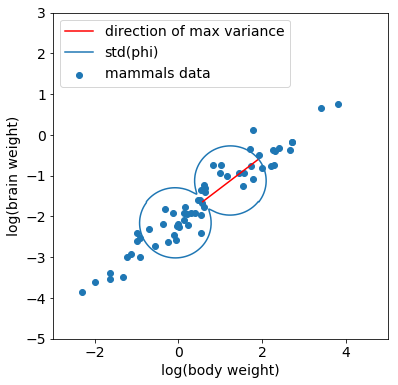

In [10]:
'''show brute force result from before'''
fig = plt.figure(figsize=(6, 6))
plt.scatter(X[0], X[1], label='mammals data') # raw data log body weight, log brain weight

# vector in direction of max variance at phi with size std:
m = X.mean(axis=1)                              # mean of the both data dimensions
phim = np.argmax(variances)*np.pi/180           # phi in rad at position of maximal variance
vmax = variances.max()                          #    and corresponding value of variance  
emax = np.asarray([np.cos(phim), np.sin(phim)]) # the projection vector itself in direction phi 
dxy = np.asarray([m, m+np.sqrt(vmax)*emax])     # starting from mean, heading in direction emax by std
plt.plot(dxy[:,0], dxy[:,1], 'r-', label='direction of max variance')

# the standard deviations in tested direction phi around the mean
phis = np.linspace(0, 2*np.pi, 361)           # turn full circle in 360 degrees
varis = np.hstack((variances, variances))     # double 0..180° as 0..360°
s = m + [np.sqrt(v)*np.asarray([np.cos(phi), np.sin(phi)]) for v, phi in zip(varis, phis)] # all std(all phi)
plt.plot(s[:,0], s[:,1], label='std(phi)')    # separate x, y of standard deviation vectors around mean
plt.axis((-3, 5, -5, 3))
plt.ylabel('log(brain weight)')
plt.xlabel('log(body weight)')
print('max variance {:.2f} at ({:.3f}, {:.3f})'.format(vmax, emax[0], emax[1]))
plt.legend(loc='upper left');

# Datenreduktion 
## auf eine Dimension "*allgemeines Gewicht*"
<br>
$$\begin{align}
y_i = d_1\cdot x_{i1} +  d_2\cdot x_{i2} &= \mathbf{d}\cdot\mathbf{x}_i \\
\begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{pmatrix} &= 
\begin{pmatrix} d_1 \; d_2 \end{pmatrix} 
\begin{pmatrix} x_{11} \; x_{12} \dots x_{1n} \\ x_{21} \; x_{22} \dots x_{2n} \end{pmatrix}
\end{align}$$

mit der (hier) $1\times 2$ Projektionsmatrix $\mathbf{D} = \begin{pmatrix}\mathbf{d}^T\end{pmatrix}$, allgemein:
$$\mathbf{Y}=\mathbf{D}\,\mathbf{X}$$

In [11]:
'''new mammals data from projection onto max variance; show sorted'''
print('original variables x have shape {}'.format(X.shape))
print('tranformation vector has shape  {}'.format(emax.shape))
y = np.dot(emax, X)                                          # project onto new vector of max variance
print('new variable y has shape        {}'.format(y.shape))
data['log_YWeight'] = y                                      # and add to dataset
print(data.sort_values(by='log_YWeight', ascending=False).head(16))

original variables x have shape (2, 62)
tranformation vector has shape  (2,)
new variable y has shape        (62,)
     BodyWt  BrainWt          Species  log_BodyWt  log_BrainWt  log_YWeight
0   6654.00   5712.0  Africanelephant    3.823083     0.756788     3.478556
4   2547.00   4603.0    Asianelephant    3.406029     0.663041     3.092196
20   529.00    680.0          Giraffe    2.723456    -0.167491     2.042995
28   521.00    655.0            Horse    2.716838    -0.183759     2.027764
11   465.00    423.0              Cow    2.667453    -0.373660     1.871934
40   250.00    490.0            Okapi    2.397940    -0.309804     1.698868
23   207.00    406.0          Gorilla    2.315970    -0.391474     1.583994
13   187.10    419.0           Donkey    2.272074    -0.377786     1.557830
33    62.00   1320.0              Man    1.792392     0.120574     1.486657
44   192.00    180.0              Pig    2.283301    -0.744727     1.340766
7    160.00    169.0   Braziliantapir    2.204120

## Rücktransformation

shapes of y=(62,) and d=(2,)
shapes of z=(2, 62)
shapes of x=(2, 62)


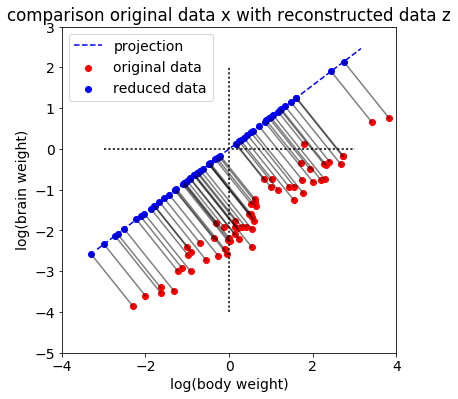

In [12]:
'''back transformation onto brain and body weights'''
print('shapes of y={} and d={}'.format(y.shape, emax.shape))
e2 = emax.reshape((emax.shape[0], 1))     # make a 2x1 "Matrix"
z = np.multiply(e2, y)                    # reconstruct 2 dimensions
print('shapes of z={}'.format(z.shape))   # new 2D reconstructed vector
print('shapes of x={}'.format(X.shape))   # old 2D data vector
plt.figure(figsize=(6,6))
xm = X.mean(axis=1)                       # means of data x
zm = z.mean(axis=1)                       # means of data z
for xx, xy, zx, zy in zip(X[0], X[1], z[0], z[1]):
    plt.plot([xx, zx], [xy, zy], 'k-', alpha=.5)
plt.scatter(X[0], X[1], c='r', label='original data')
plt.scatter(z[0], z[1], c='b', label='reduced data')
plt.plot(2*[0], [-4, 2], 'k:')
plt.plot([-3, 3], 2*[0], 'k:')
plt.plot([-4*emax[0], 4*emax[0]], [-4*emax[1], 4*emax[1]] , 'b--', label='projection')
plt.title('comparison original data x with reconstructed data z')
plt.xlabel('log(body weight)')
plt.ylabel('log(brain weight)')
plt.axis((-4, 4, -5, 3))
plt.legend(loc='upper left');

# Zusammenfassung I
- Unterraum (hier eine Dimension) erlaubt Datenreduktion
- *Bester* Unterraum erhält maximale Varianz
    - Richtungsvektor
- Projektion in Unterraum
    - auf Richtungsvektor
    - hier: 2D -> 1D
- Rekonstruktion mittels Umkehrprojektion
    - aus Richtungsvektor
- Mittelwertskorrektur für direkten Vergleich
    - später mehr

# Datenreduktion II
## Weitere Dimension(en)
### Schlafdauer


In [13]:
data = animals[['BodyWt', 'BrainWt', 'TotalSleep']]
data = data.dropna(axis=0)    # drop lines (axis=0) without all values
data['log_BodyWt'] = np.log10(animals['BodyWt'])
data['log_BrainWt'] = np.log10(animals['BrainWt'])-3
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 60
Data columns (total 5 columns):
BodyWt         58 non-null float64
BrainWt        58 non-null float64
TotalSleep     58 non-null float64
log_BodyWt     58 non-null float64
log_BrainWt    58 non-null float64
dtypes: float64(5)
memory usage: 2.7 KB


shape of data v: (3, 58)
Means:               [  0.496  -1.689  10.533]
Standard deviations: [ 1.3325  1.0555  4.5669]


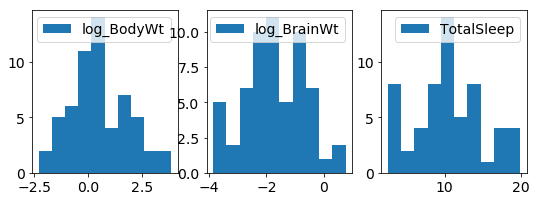

In [14]:
variables = ['log_BodyWt', 'log_BrainWt', 'TotalSleep']
v = np.asarray(data[variables]).T
print('shape of data v: {}'.format(v.shape))
fig = plt.figure(figsize=(12,3))
for i in range(v.shape[0]):
    fig.add_subplot(1, 4, i+1)
    plt.hist(v[i], label=variables[i])
    plt.legend();
vmeans = v.mean(axis=1)
vstds = v.std(axis=1)
print('Means:               {}'.format(np.round(vmeans, decimals=3)))
print('Standard deviations: {}'.format(np.round(vstds, decimals=4)))

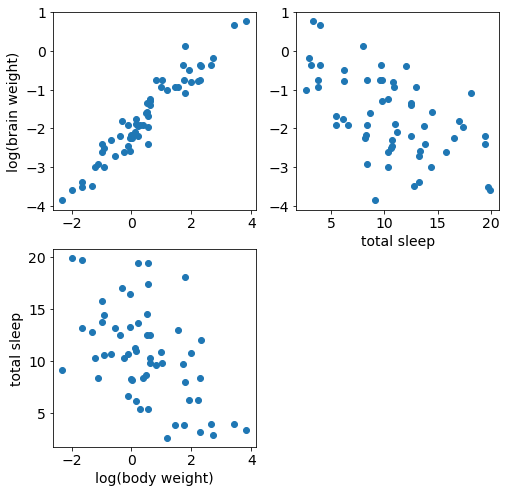

In [15]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(2, 2, 1)
plt.scatter(v[0], v[1])
plt.ylabel('log(brain weight)')
fig.add_subplot(2, 2, 2)
plt.scatter(v[2], v[1])
plt.xlabel('total sleep')
fig.add_subplot(2, 2, 3)
plt.scatter(v[0], v[2])
plt.xlabel('log(body weight)')
plt.ylabel('total sleep');

<IPython.core.display.Javascript object>


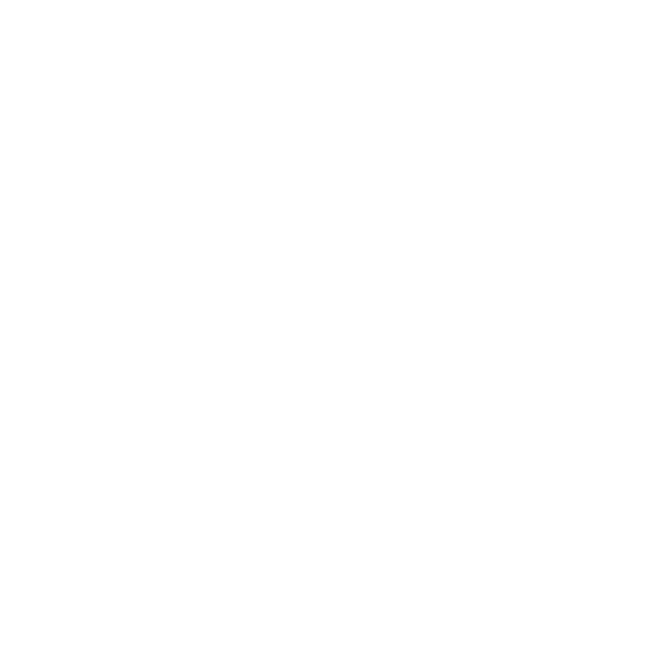

<IPython.core.display.Javascript object>


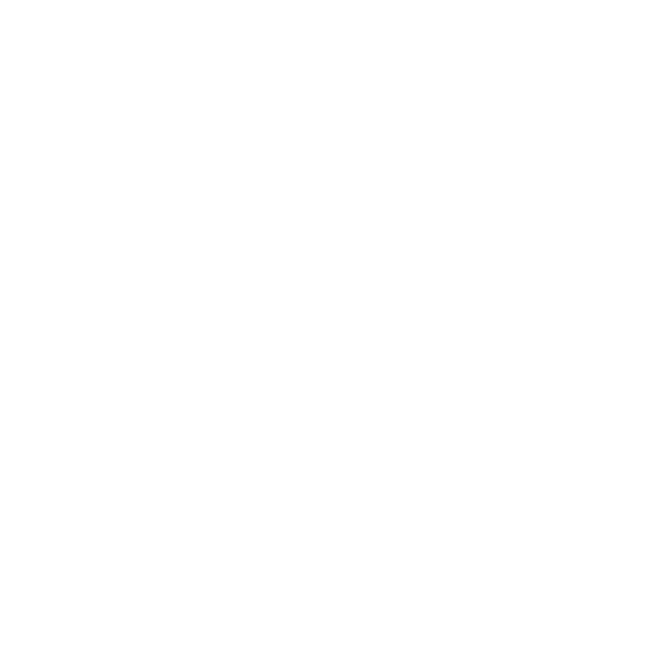

In [16]:
# from mpl_toolkits.mplot3d.axes3d import Axes3D    # allows 3D plots (already on top)
%matplotlib notebook                                    
#              ^---- for interactive plot (deactivates "%matplotlib inline")
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)
ax.scatter(v[0], v[1], v[2], c='b', marker='o')
ax.view_init(elev=60, azim=-45)
ax.set_xlabel('log(body weight)')
ax.set_ylabel('log(brain weight)')
ax.set_zlabel('total sleep)');
# now, an interactive 3D image shows up

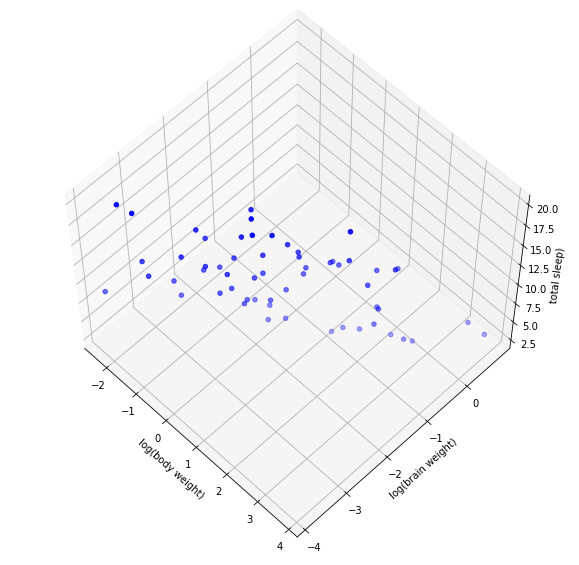

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(v[0], v[1], v[2], c='b', marker='o')
ax.view_init(elev=60, azim=-45)
ax.set_xlabel('log(body weight)')
ax.set_ylabel('log(brain weight)')
ax.set_zlabel('total sleep)');

In [21]:
%matplotlib inline

# Maximale Varianz?

## Verschiebung: Zentrieren
$$\mathbf{a} := \mathbf{v}-\overline{\mathbf{v}}$$
- originale Daten $\mathbf{v}$
- zentrierte Daten $\mathbf{a}$
- Löst Mittelwert-Problem von vorhin
- Vereinfacht Berechnungen

$$\mathbf{A} := \mathbf{V}-\overline{\mathbf{v}}$$

## Kovarianzmatrix $\quad\mathrm{Cov}(X_i, X_k)$ 

$$C_{ik} = \frac{1}{m}\sum_{j=1}^m (v_{ij}-\overline{v}_i)(v_{kj}-\overline{v}_k) = \frac{1}{m}\sum_{j=1}^m a_{ij}a_{kj}$$

Mittels Datenmatrix $\mathbf{A}$ aus Spalten $\mathbf{a}_i$, so daß

$$\mathbf{C} = \frac{1}{m}\mathbf{AA}^T$$

## Projektion

Projektion aller Daten $\mathbf{v}$ auf beliebige Richtung $\mathbf{w}$ ergibt

Quelle: Prof. V. Blanz, Uni Siegen


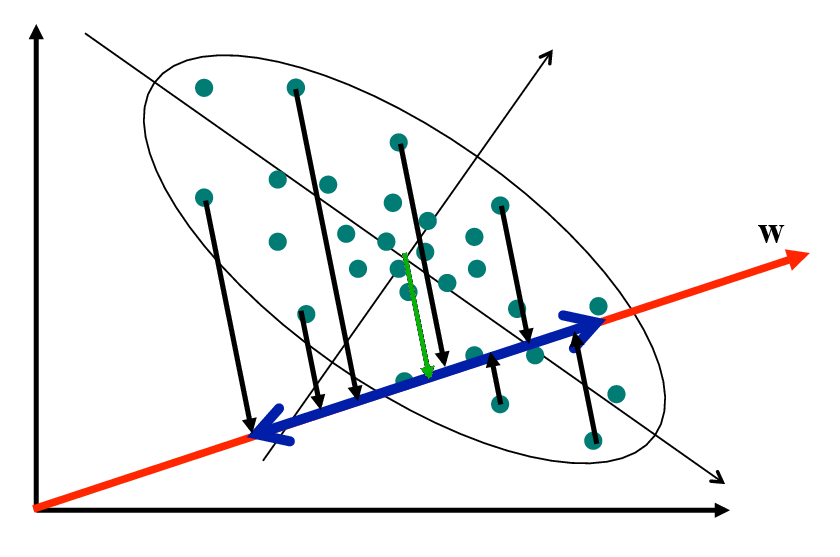

<img src="images/pca_projection_vb.png" width="25%">

$$\qquad\mathcal{E}(\mathbf{w}\cdot\mathbf{v}) = \frac{1}{m}\sum_{j=1}^m \mathbf{w}\cdot\mathbf{v}_j
=\mathbf{w}\cdot\sum_{j=1}^m \frac{1}{m}\mathbf{v}_j = \mathbf{w}\cdot\overline{\mathbf{v}}$$

$$\begin{align}
\mathrm{Var}(\mathbf{w}\cdot\mathbf{v}) &= \frac{1}{m}\sum_{j=1}^m (\mathbf{w}\cdot\mathbf{v}_j - \mathbf{w}\cdot\overline{\mathbf{v}})^2 =\frac{1}{m}\sum_{j=1}^m (\mathbf{w}\cdot(\mathbf{v}_j - \overline{\mathbf{v}}))^2 \\
&=\frac{1}{m}\sum_{j=1}^m (\mathbf{w}\cdot \mathbf{a}_j)^2 =\frac{1}{m}\sum_{j=1}^m\sum_{i=1}^n\sum_{k=1}^n w_ia_{ij}a_{kj}w_k \\
&=\frac{1}{m}\mathbf{w}\cdot\mathbf{A}\mathbf{A}^T\mathbf{w} = \mathbf{w}\cdot\mathbf{C}\mathbf{w}
\end{align}$$

# Singularwertzerlegung, singular value decomposition *SVD *  I

Daten $m\times n$ (hier im Bsp. Tiere $\times$ Variablen)

Unterraum $\mathbf{K}$ < $\mathbf{M}$ mit Hauptkomponenten $i\in [1\dots K]$. Meist $\;K\ll n$.

Aber nicht nur sortiert sondern auch noch gedreht.


Quelle: Prof. V. Blanz, Uni Siegen


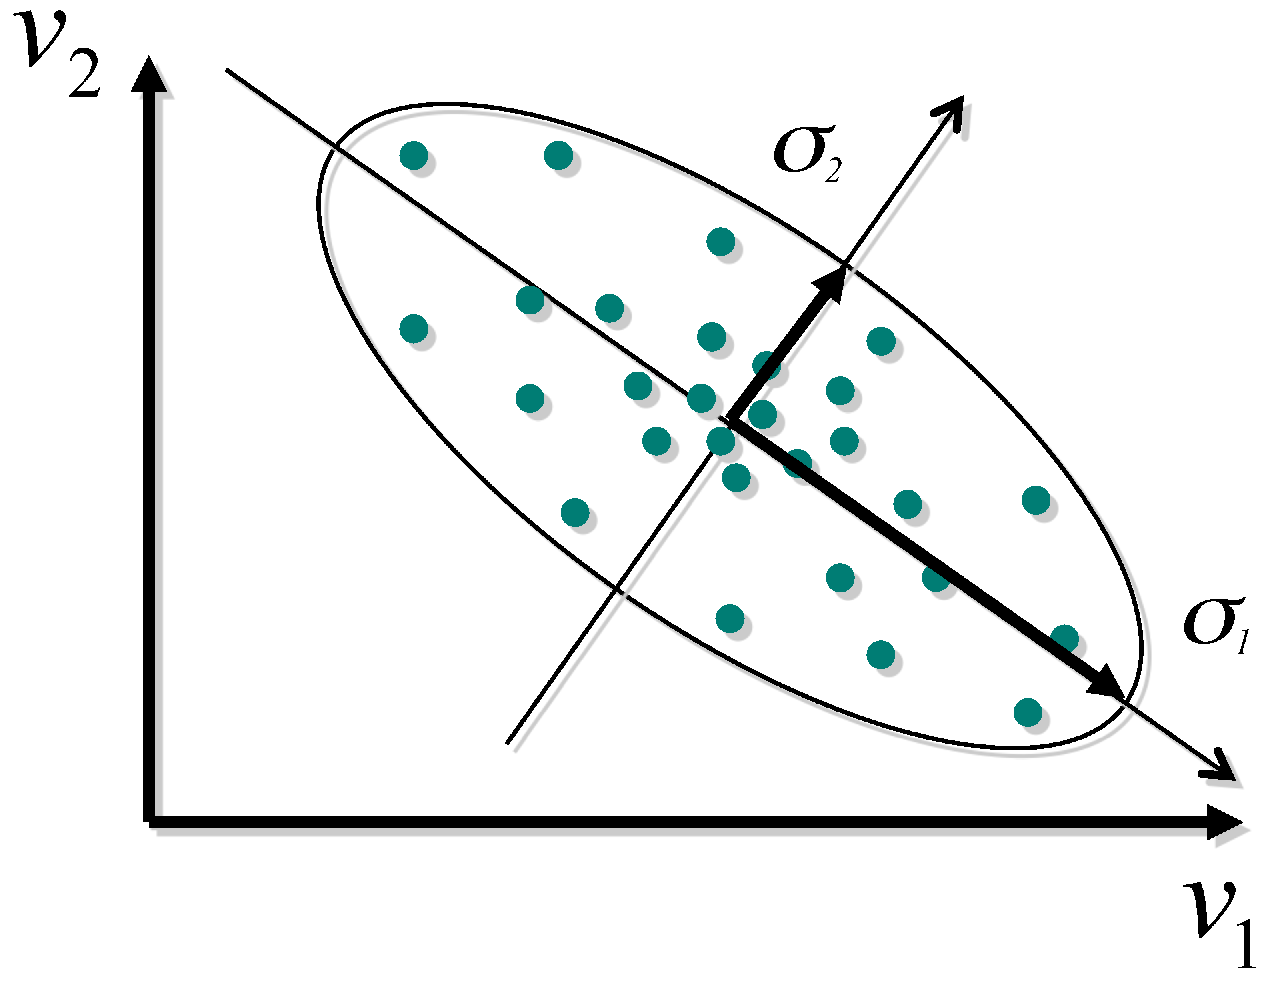

#### Finde Unterraum mit größter Varianz!

## Diagonalisieren der Kovarianzmatrix $\mathbf{C}$

Wegen Symmetrie existiert 

$$\mathbf{C}=\mathbf{U}\mathbf{\Lambda}\mathbf{U}^T$$

mit orthonormaler Matrix $\mathbf{U}$ und Diagonalmatrix $\mathbf{\Lambda}$.


Dabei sind Eigenvektoren $\mathbf{u}_i$ von $\mathbf{C}$ in den Spalten von $\mathbf{U}$:

$$\mathbf{C}\mathbf{u}_i=\lambda_i\mathbf{u}_i$$

und (positive) Eigenwerte $\lambda_i$ mit

$$\sigma_i^2=Var(\mathbf{u}_i\cdot\mathbf{v})= \mathbf{u}_i\cdot\mathbf{C}\mathbf{u}_i = \mathbf{u}_i\cdot\lambda_i\mathbf{u}_i=\lambda_i$$

### $\Rightarrow$ Die Diagonalmatrix $\mathbf{\Lambda}$ enthält als Eigenwerte die projizierten Varianzen

# Unterräume

$$\text{max}( \mathrm{Var})= \text{max}(\mathbf{w}\cdot\mathbf{C}\mathbf{w})$$

#### Größte Varianz
in Richtung des (normierten) Eigenvektors 
$$\mathbf{u_{(1)}}$$
zum größten Eigenwert 
$$\lambda_{(1)} = \text{max}(\lambda_i)$$

## Erste Hauptkomponente *principal component*


## Beschränkung
auf Unterraum orthogonal zur ersten Hauptkomponente.

Wird von restlichen Eigenvektoren aufgespannt (Orthogonalsystem wegen Symmetrie von $\mathbf{C}$)

## Zweite Hauptkomponente
im Unterraum **ohne** die erste Hauptkomponente entspricht dann dem Eigenvektor zum zweitgrößten Eigenwert.

Zweitgrößte Varianz in Richtung des (normierten) Eigenvektors 
$$\mathbf{u_{(2)}}$$
zum zweitgrößten Eigenwert 
$$\lambda_{(2)} = \text{max}(\lambda_{i\neq(1)})$$

## Und so weiter...

Praktischerweise Abschneiden ab $\lambda_r$ < Schwelle

Verbleibender Unterraum hat kaum Beitrag zur Varianz

Abbruchkriterium beispielsweise durch Test auf Signifikanz...

# Zusammenfassung II

- Kovarianzmatrix $\mathbf{C}$ aus Datenmatrix $\mathbf{A}$ bestimmen
$$\mathbf{C} = \frac{1}{m}\mathbf{AA}^T$$
- Diagonalisieren
$$\mathbf{C}=\mathbf{U}\mathbf{\Lambda}\mathbf{U}^T$$
- Sortiere Eigenvektoren $\mathbf{u}_i$ der Größe der Eigenwerte $\lambda_i$ nach
$$\lambda_{(1)}\geq\lambda_{(2)}\geq\dots$$
- Erste Eigenvektoren spannen Unterraum $\mathbf{U}$ mit jeweils größtmöglicher Varianz auf
- Hauptkomponenten aus Projektion in  $\mathbf{U}$
$$\boldsymbol\alpha = \mathbf{U a}$$
- Abschneiden nach Unterschreiten einer Schwelle für Eigenwerte

## Daten
Datenmatrix $n\times m$
$$\mathbf{v} = (v_{ij})$$
$m=58$ Tiere $j$: {Elefant, ...} <br>
$n=3$ Variablen $i$: {BodyWt, BrainWt, SleepTime}

### Mittelwerte der Variablen $i$
$\mathbf{\bar{v}} = \frac{1}{m}\sum_{j=1}^m \mathbf{v}_j$ abziehen
$$\mathbf{a} = \mathbf{v}-\mathbf{\bar{v}}$$

### Dann Varianz in den zentrierten Variablen $i$
$$\mathrm{Var}_i = \frac{1}{m}\sum_{j=1}^m a_{ij}^2$$

In [18]:
'''subtract mean and calculate variances'''
print('data shape v = {}'.format(v.shape))
vmeans = v.mean(axis=1)                      # the means of all variables
a = (v.T-vmeans).T                           # two times transposing in order to hit the right dimension
print('data shape a = {}'.format(a.shape))
variances = a.var(axis=1)                    # the variances of all variables
print('animals data a have variances {}'.format(variances))

data shape v = (3, 58)
data shape a = (3, 58)
animals data a have variances [  1.77549851   1.11417243  20.85634067]


## Kovarianzmatrix
$$\mathbf{C} = \frac{1}{m}\mathbf{AA}^T$$

Erinnerung: Variable $i$ gegen Variable $k$ über alle Tiere $j=1\dots m$
$$C_{ik} = \frac{1}{m}\sum_{j=1}^m (v_{ij}-\overline{v}_i)(v_{kj}-\overline{v}_k) = \frac{1}{m}\sum_{j=1}^m a_{ij}a_{kj}$$

In [19]:
print('data Matrix A has shape {}'.format(a.shape))
C = 1./a.shape[1] * np.dot(a, a.T)
print('covariance matrix C has shape {}'.format(C.shape))
print(C)

data Matrix A has shape (3, 58)
covariance matrix C has shape (3, 3)
[[  1.77549851   1.34779228  -3.24243701]
 [  1.34779228   1.11417243  -2.71201272]
 [ -3.24243701  -2.71201272  20.85634067]]


### Diagonalisieren

In [20]:
'''calculate Eigen vectors and Eigen values'''
EW, EV = np.linalg.eig(C)

print('{} ... Eigen values'.format(np.round(EW, decimals=3)))
print('{} ... Eigen vectors'.format(np.round(EV, decimals=3)))

print('\ntest, if Eigenvector, Eigenvalue:')
for vec, val in zip(EV.T, EW):
    np.testing.assert_allclose(np.dot(C, vec), val*vec)   # no exception if within accuracy = zero
    print(np.dot(C, vec))
    print(val * vec)

[ 21.798   1.892   0.056] ... Eigen values
[[-0.167 -0.778 -0.606]
 [-0.139 -0.59   0.795]
 [ 0.976 -0.217  0.009]] ... Eigen vectors

test, if Eigenvector, Eigenvalue:
[ -3.64922058  -3.02744908  21.27642658]
[ -3.64922058  -3.02744908  21.27642658]
[-1.47118344 -1.11602693 -0.41113049]
[-1.47118344 -1.11602693 -0.41113049]
[-0.03384112  0.04442026  0.00051636]
[-0.03384112  0.04442026  0.00051636]


### Sortieren

In [21]:
'''sort Eigen-vectors by Eigen-values'''
liste = [(np.abs(ew), ev) for ew, ev in zip(EW, EV.T)]
liste.sort()                    # sorting is (1)<=(2)<=(3)...
liste.reverse()                 # we want biggest first
for li in liste:
    print('Eigen value {:8.4f} with Eigen vector {}'.format(li[0], np.round(li[1], decimals=4)))

Eigen value  21.7984 with Eigen vector [-0.1674 -0.1389  0.9761]
Eigen value   1.8918 with Eigen vector [-0.7777 -0.5899 -0.2173]
Eigen value   0.0558 with Eigen vector [-0.606   0.7954  0.0092]


### Unterraum $U'$
mit zwei größten Eigenwerten in Spalten:

In [22]:
'''take only first two principal directions with biggest Eigen value from sorted list'''
Uprime = np.hstack((liste[0][1].reshape(3,1), liste[1][1].reshape(3,1)))
print('Matrix of first two Eigen vectors: \n{}'.format(Uprime))

Matrix of first two Eigen vectors: 
[[-0.16740802 -0.77766136]
 [-0.13888425 -0.58992713]
 [ 0.97605621 -0.21732184]]


In [23]:
'''orthogonal?'''
print('u0 dot u1 = {} -> orthogonal'.format(np.dot(Uprime.T[0], Uprime.T[1])))

u0 dot u1 = 1.3877787807814457e-16 -> orthogonal


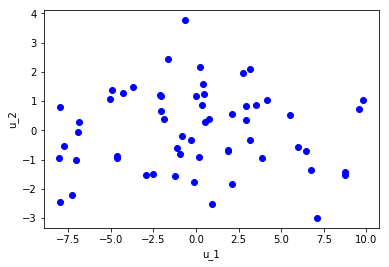

In [24]:
'''transform into 2D subspace '''
y = Uprime.T.dot(a)     # all 58 datasets in two dimensional subspace of EV1 and EV2
plt.plot(y[0], y[1], 'bo')
plt.xlabel('u_1')
plt.ylabel('u_2');

### Graphisch in originalen 3D Daten

In [25]:
from mpl_toolkits.mplot3d import Axes3D             # already, no harm, to remember
from matplotlib.patches import FancyArrowPatch      # as the name suggests ...
from mpl_toolkits.mplot3d import proj3d             # allows 3D to 2D graphics projection

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


<IPython.core.display.Javascript object>


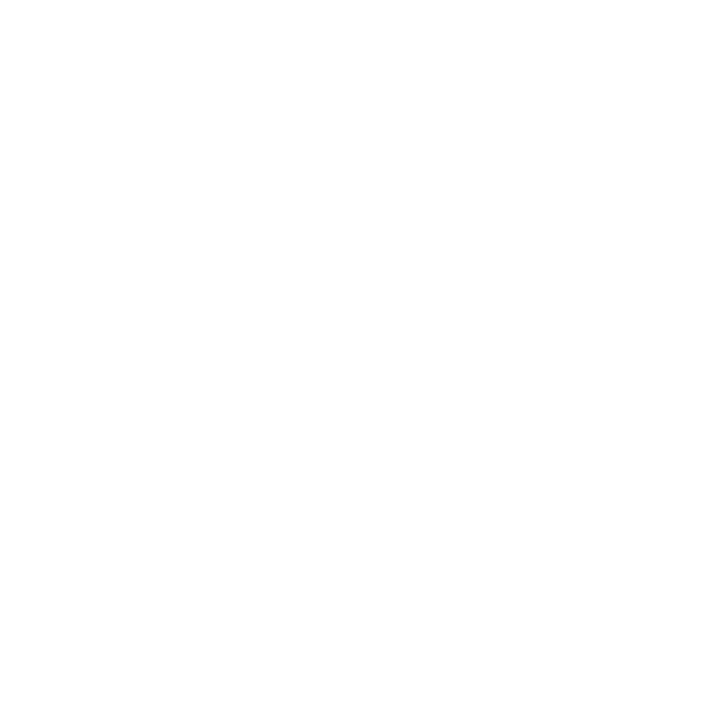

<IPython.core.display.Javascript object>


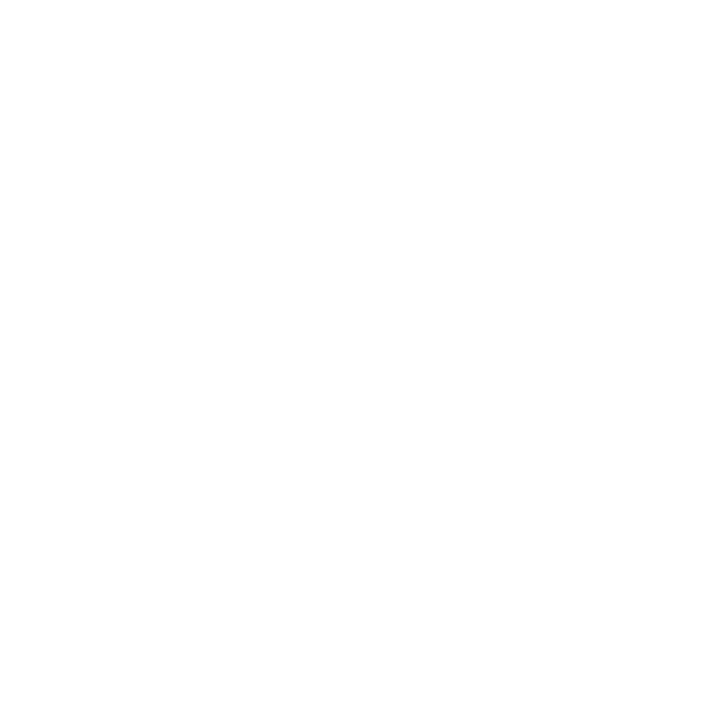

In [26]:
%matplotlib notebook                                  
#              ^---- for interactive plot within notebook (should deactivate "%matplotlib inline")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(v[0], v[1], v[2], c='b', marker='o')
ax.view_init(elev=60, azim=-45)
ax.set_xlabel('log(body weight)')
ax.set_ylabel('log(brain weight)')
ax.set_zlabel('total sleep)')

vm = np.array(vmeans)
arr = Arrow3D([0, vm[0]], [0, vm[1]], [0, vm[2]], 
              mutation_scale=20, lw=3, arrowstyle="-|>", color="g")
ax.add_artist(arr) 
u = vm + np.sqrt(EW[0])*Uprime.T[0]      # first Eigen vector + mean
# vm = np.array([0, 0, 0])
arr = Arrow3D([vm[0], u[0]], [vm[1], u[1]], [vm[2], u[2]], 
              mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
ax.add_artist(arr)
u = vm + np.sqrt(EW[1])*Uprime.T[1]      # second Eigen vector + mean
arr = Arrow3D([vm[0], u[0]], [vm[1], u[1]], [vm[2], u[2]], 
              mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
ax.add_artist(arr)
plt.title('plane with first two Eigen vectors')
# plt.show()                             # only needed, if neither inline nor notebook
# now, an interactive 3D image shows up

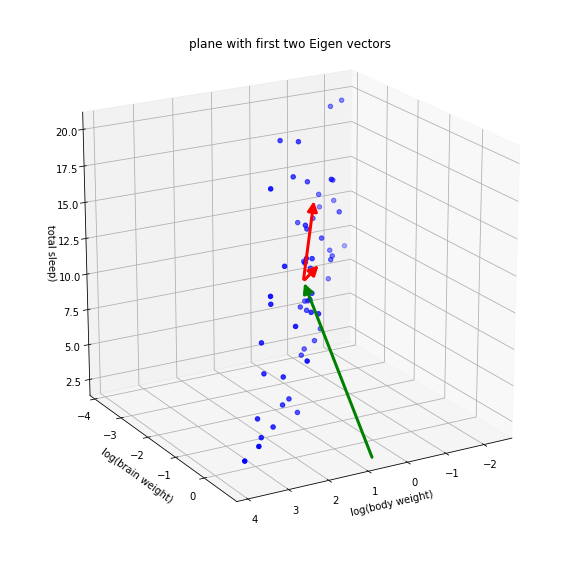

In [28]:
%matplotlib inline
#              ^---- for static plot inside notebook (should deactivate "%matplotlib notebook")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(v[0], v[1], v[2], c='b', marker='o')
ax.view_init(elev=20, azim=60)
ax.set_xlabel('log(body weight)')
ax.set_ylabel('log(brain weight)')
ax.set_zlabel('total sleep)')

vm = np.array(vmeans)
arr = Arrow3D([0, vm[0]], [0, vm[1]], [0, vm[2]], 
              mutation_scale=20, lw=3, arrowstyle="-|>", color="g")
ax.add_artist(arr)
u = vm + np.sqrt(EW[0])*Uprime.T[0]      # first Eigen vector + mean
# vm = np.array([0, 0, 0])
arr = Arrow3D([vm[0], u[0]], [vm[1], u[1]], [vm[2], u[2]], 
              mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
ax.add_artist(arr)
u = vm + np.sqrt(EW[1])*Uprime.T[1]      # second Eigen vector + mean
arr = Arrow3D([vm[0], u[0]], [vm[1], u[1]], [vm[2], u[2]], 
              mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
ax.add_artist(arr)
plt.title('plane with first two Eigen vectors');


# Literatur
#### Bücher, Kapitel
- Hyvärinen, Hurri, Hoyer: Natural Image Statistics - A Probabilistic Approach to Early Computational Vision. Springer 2009
- [Abdi, Williams: Principal component analysis. Wiley 2010](http://onlinelibrary.wiley.com/doi/10.1002/wics.101/abstract)

#### Python
- scipy/numpy Vektoroperationen: [http://www.scipy-lectures.org/intro/numpy/operations.html]
- Matrixoperationen numpy, R, Matlab & Julia: [https://sebastianraschka.com/blog/2014/matrix_cheatsheet_table.html]
- matplotlib 3D Plot [https://matplotlib.org/mpl_toolkits/mplot3d/index.html]

# Zusammenfassung PCA
- Lineare Algebra
- Nicht-parametrische Methode
- Datenreduktion
- Erhaltung maximaler Varianz


### Prinzip
- Suche maximale Varianz "*Musik*" in Daten
- Kovarianzmatrix $\mathbf{C}$
- Diagonalisieren
- Eigenwerte $\lambda_i$
    - Varianz in Richtung des Eigenvektors
    - sortieren
    - abschneiden
- Eigenvektoren $\mathbf{u_i}$
    - *Hauptkomponenten*
- Unterräume mit Eigenvektoren
    - Raum maximaler Varianz
    - Rücktransformation
- Komponentenanalyse
- Rücktransformation